# pIC50 Test

In [1]:
import numpy as np
import torch
import seaborn as sns
import malt
import pandas as pd
import dgllife

Using backend: pytorch


In [2]:
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
df = pd.read_csv('../../../data/moonshot_pIC50.csv', index_col=0)

dgllife_dataset = dgllife.data.csv_dataset.MoleculeCSVDataset(
    df=df,
    smiles_to_graph=smiles_to_bigraph,
    node_featurizer=CanonicalAtomFeaturizer(),
    edge_featurizer=CanonicalBondFeaturizer(),
    smiles_column='SMILES',
    task_names=[
        # 'MW', 'cLogP', 'r_inhibition_at_20_uM',
        # 'r_inhibition_at_50_uM', 'r_avg_IC50', 'f_inhibition_at_20_uM',
        # 'f_inhibition_at_50_uM', 'f_avg_IC50', 'relative_solubility_at_20_uM',
        # 'relative_solubility_at_100_uM', 'trypsin_IC50',
        'f_avg_pIC50'
    ],
    init_mask=False,
    cache_file_path='../../../data/moonshot_pIC50.bin'
)

Processing dgl graphs from scratch...
Processing molecule 1000/2260
Processing molecule 2000/2260


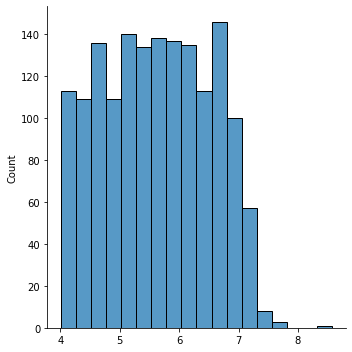

In [3]:
sns.displot(dgllife_dataset.labels.numpy()[dgllife_dataset.labels.numpy() > 4.005])

In [1]:
from malt.data.collections import _dataset_from_dgllife

data = _dataset_from_dgllife(dgllife_dataset)

# mask data if it's at the limit of detection
data_masked = data[list(np.flatnonzero(np.array(data.y) > 4.005))]
data.shuffle(seed=2666)
ds_tr, ds_vl, ds_te = data_masked[:1500].split([8, 1, 1])

Using backend: pytorch


NameError: name 'dgllife_dataset' is not defined

Make model

In [10]:
model_choice = 'nn' # 'nn'
if model_choice == "gp":
    model = malt.models.supervised_model.GaussianProcessSupervisedModel(
        representation=malt.models.representation.DGLRepresentation(
            out_features=128,
        ),
        regressor=malt.models.regressor.ExactGaussianProcessRegressor(
            in_features=128, out_features=2,
        ),
        likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
    )


elif model_choice == "nn":
    model = malt.models.supervised_model.SimpleSupervisedModel(
        representation=malt.models.representation.DGLRepresentation(
            out_features=128,
        ),
        regressor=malt.models.regressor.NeuralNetworkRegressor(
            in_features=128, out_features=1,
        ),
        likelihood=malt.models.likelihood.HomoschedasticGaussianLikelihood(),
    )

Train and evaluate.

In [11]:
trainer = malt.trainer.get_default_trainer(
    without_player=True,
    batch_size=32, # len(ds_tr),
    n_epochs=3000,
    learning_rate=1e-3
)
model = trainer(model, ds_tr)

r2 = malt.metrics.supervised_metrics.R2()(model, ds_te)
print(r2)

rmse = malt.metrics.supervised_metrics.RMSE()(model, ds_te)
print(rmse)

tensor(-0.7225, grad_fn=<RsubBackward1>)
tensor(1.0590, grad_fn=<SqrtBackward0>)


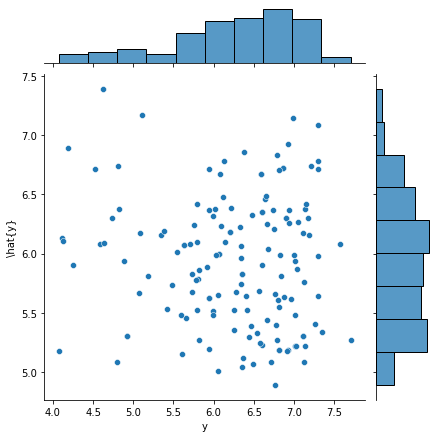

In [12]:
ds_te_loader = ds_te.view(batch_size=len(ds_te))
g, y = next(iter(ds_te_loader))
y_hat = model.condition(g).mean
g = sns.jointplot(x = ds_te.y, y = y_hat.detach().numpy().ravel())
g.set_axis_labels('y', '\hat{y}')

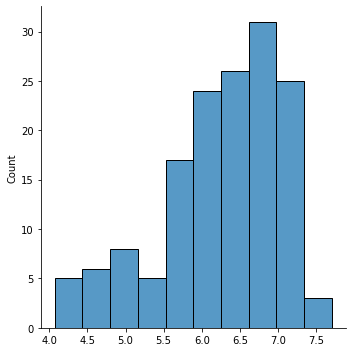

In [14]:
sns.displot(ds_te.y)

In [19]:
import torch
import dgl
import malt
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--data", type=str, default="esol")
parser.add_argument("--model", type=str, default="gp")

args = parser.parse_args([])

data = getattr(malt.data.collections, args.data)()
data.shuffle(seed=2666)
ds_tr, ds_vl, ds_te = data.split([8, 1, 1])

if args.model == "gp":
    model = malt.models.supervised_model.GaussianProcessSupervisedModel(
        representation=malt.models.representation.DGLRepresentation(
            out_features=128,
        ),
        regressor=malt.models.regressor.ExactGaussianProcessRegressor(
            in_features=128, out_features=2,
        ),
        likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
    )


elif args.model == "nn":
    model = malt.models.supervised_model.SimpleSupervisedModel(
        representation=malt.models.representation.DGLRepresentation(
            out_features=128,
        ),
        regressor=malt.models.regressor.NeuralNetworkRegressor(
            in_features=128, out_features=1,
        ),
        likelihood=malt.models.likelihood.HomoschedasticGaussianLikelihood(),
    )


trainer = malt.trainer.get_default_trainer(without_player=True, batch_size=len(ds_tr), n_epochs=3000, learning_rate=1e-3)
model = trainer(model, ds_tr)

r2 = malt.metrics.supervised_metrics.R2()(model, ds_te)
print(r2)

rmse = malt.metrics.supervised_metrics.RMSE()(model, ds_te)
print(rmse)

Processing dgl graphs from scratch...
Processing molecule 1000/1128


In [39]:
ds_tr.view(by=['g'], batch_size=)

In [44]:
model.condition(ds_tr.batch(by=['g']))

Normal(loc: torch.Size([902, 1]), scale: torch.Size([902, 1]))

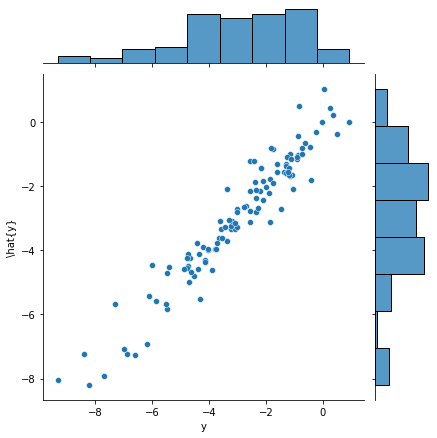

In [16]:
ds_te_loader = ds_te.view(batch_size=len(ds_te))
g, y = next(iter(ds_te_loader))
y_hat = model.condition(g).mean
g = sns.jointplot(x = ds_te.y, y = y_hat.detach().numpy())
g.set_axis_labels('y', '\hat{y}')